In [1]:
import pandas as pd
import numpy as np
import os, glob, pickle, configparser
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
import nibabel as nib
from nilearn import plotting, surface


exp_config = configparser.ConfigParser()
exp_config.read('../config')
NSD_top_dir = exp_config['DIR']['NSD_top_dir']
results_dir = os.path.join(NSD_top_dir, 'results')

modality_list = ['img']
sub_list = range(1, 9)

In [2]:
lPFC_results_dir = os.path.join(results_dir, 'CV_results_CLIP')
output_fig_dir = os.path.join(NSD_top_dir, 'figures', 'Manuscript')

In [3]:
for curr_sub in sub_list:
    curr_sub_df_dir = os.path.join(lPFC_results_dir, 'sub0{}_img_GS_norm.csv'.format(curr_sub))
    curr_sub_df = pd.read_csv(curr_sub_df_dir, header=None, names=['SUB', 'VERTEX', 'CV-r', 'best alpha'])
    if curr_sub == 1:
        summary_df = curr_sub_df
    else:
        summary_df = pd.concat([summary_df, curr_sub_df]).reset_index(drop=True)

In [4]:
summary_df['modality'] = 'img'

In [7]:
summary_df.groupby(by='SUB')['CV-r'].mean().round(2)

SUB
1    0.36
2    0.39
3    0.20
4    0.29
5    0.42
6    0.23
7    0.34
8    0.11
Name: CV-r, dtype: float64

In [8]:
summary_df.groupby(by='SUB')['CV-r'].std().round(2)

SUB
1    0.09
2    0.08
3    0.10
4    0.09
5    0.11
6    0.07
7    0.09
8    0.07
Name: CV-r, dtype: float64

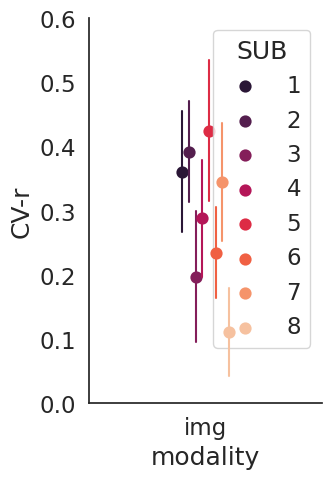

In [38]:
plt.figure(figsize=(3,5))
sns.set(font_scale=1.5)
sns.set_style('white')
sns.pointplot(x='modality', y='CV-r', hue='SUB', errorbar='sd', palette='rocket',errwidth=1.5,
              dodge=True, data=summary_df)
sns.despine(top=True, right=True)
plt.ylim([0, 0.6])
#plt.legend([])
plt.savefig(os.path.join(output_fig_dir, 'CLIP_pred.pdf'), dpi=50)

# Draw the anatomical distribution

In [9]:
mask_output_dir = os.path.join(NSD_top_dir, 'intermediate', 'masks', 'HCP_MMP_ROIs')

In [10]:
def generate_r_mask(lh_mask, rh_mask, rs_df, variable):
    # Separate the dataframe in to left and righ hemispheres
    lh_rs_df = rs_df[rs_df['VERTEX']<np.sum(lh_mask)]
    rh_rs_df = rs_df[rs_df['VERTEX']>=np.sum(lh_mask)]
    rh_rs_df['VERTEX'] = rh_rs_df['VERTEX']-np.sum(lh_mask)
    
    # Fill the values into the masks
    lh_mask_nozero = np.where(lh_mask)
    lh_mask_thresh = np.zeros(lh_mask.shape)
    lh_mask_thresh[:] = np.nan
    lh_mask_thresh[lh_mask_nozero[0][lh_rs_df['VERTEX'].values]] = lh_rs_df[variable].values

    rh_mask_nozero = np.where(rh_mask)
    rh_mask_thresh = np.zeros(rh_mask.shape)
    rh_mask_thresh[:] = np.nan
    rh_mask_thresh[rh_mask_nozero[0][rh_rs_df['VERTEX'].values]] = rh_rs_df[variable].values
    
    return lh_mask_thresh.astype('>f4'), rh_mask_thresh.astype('>f4')

In [58]:
vmax_curr_layer = summary_df['CV-r'].max()
for curr_sub in sub_list:
    print('Current subject:{}'.format(curr_sub))
    # Put the r values back to the brain
    lh_frontal_mask = np.load(os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.npy'.format(curr_sub)))
    rh_frontal_mask = np.load(os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.npy'.format(curr_sub)))
    print('Number of frontal vertices in lh: {}'.format(np.sum(lh_frontal_mask)))
    print('Number of frontal vertices in rh: {}'.format(np.sum(rh_frontal_mask)))
    print('Number of frontal vertices in total: {}'.format(np.sum(lh_frontal_mask)+np.sum(rh_frontal_mask)))
    
    native_surf_dir = os.path.join(NSD_top_dir,
                                   'data',
                               'nsddata', 
                               'freesurfer', 
                               'subj0{}'.format(curr_sub),
                              'surf')
    infl_right_dir = os.path.join(native_surf_dir, 'rh.inflated')
    sulc_right_dir = os.path.join(native_surf_dir, 'rh.sulc')
    infl_left_dir = os.path.join(native_surf_dir, 'lh.inflated')
    sulc_left_dir = os.path.join(native_surf_dir, 'lh.sulc')
    
    # Plot lPFC outline as contour
    lh_frontal_contour = os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.annot'.format(curr_sub))
    rh_frontal_contour = os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.annot'.format(curr_sub))
    lh_frontal_lPFC = surface.load_surf_data(lh_frontal_contour)
    rh_frontal_lPFC = surface.load_surf_data(rh_frontal_contour)
    
    curr_sub_lh_rs_mask_1, curr_sub_rh_rs_mask_1 = generate_r_mask(lh_frontal_mask,
                                                              rh_frontal_mask,
                                                              summary_df[summary_df['SUB']==curr_sub],
                                                              'CV-r')

    fig = plotting.plot_surf_stat_map(
        infl_right_dir, curr_sub_rh_rs_mask_1, hemi='right',
        title='Subj0{} (right)'.format(curr_sub), colorbar=True, vmax=vmax_curr_layer,
        bg_map=sulc_right_dir, #threshold=0,
    )
    levels = [1]
    labels = ['lPFC']
    
    plotting.plot_surf_contours(
        infl_right_dir, rh_frontal_contour, hemi='right',
        labels=labels, levels=levels,
        bg_map=sulc_right_dir, figure=fig,
        colors=['purple'],
        output_file=os.path.join(output_fig_dir, 'sub0{}_wlPFC_rh.png'.format(curr_sub))
    )

    
    fig.show()
    
    
    fig = plotting.plot_surf_stat_map(
    infl_left_dir, curr_sub_lh_rs_mask_1, hemi='left',
    title='Subj0{} (left)'.format(curr_sub), colorbar=True, vmax=vmax_curr_layer,
    bg_map=sulc_left_dir, #threshold=0,
    )
    
    plotting.plot_surf_contours(
        infl_left_dir, lh_frontal_contour, hemi='left',
        labels=labels, levels=levels,
        bg_map=sulc_left_dir, figure=fig,
        colors=['purple'],
        output_file=os.path.join(output_fig_dir, 'sub0{}_wlPFC_lh.png'.format(curr_sub))
    )
    fig.show()
    

Current subject:1
Number of frontal vertices in lh: 41584
Number of frontal vertices in rh: 41844
Number of frontal vertices in total: 83428


/lustre/home/qilin1/miniforge3/envs/GenPFC_mini/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Current subject:2
Number of frontal vertices in lh: 45459
Number of frontal vertices in rh: 46301
Number of frontal vertices in total: 91760
Current subject:3
Number of frontal vertices in lh: 43519
Number of frontal vertices in rh: 43478
Number of frontal vertices in total: 86997
Current subject:4
Number of frontal vertices in lh: 40518
Number of frontal vertices in rh: 39672
Number of frontal vertices in total: 80190
Current subject:5
Number of frontal vertices in lh: 34351
Number of frontal vertices in rh: 35400
Number of frontal vertices in total: 69751
Current subject:6
Number of frontal vertices in lh: 46528
Number of frontal vertices in rh: 46853
Number of frontal vertices in total: 93381
Current subject:7
Number of frontal vertices in lh: 35599
Number of frontal vertices in rh: 36079
Number of frontal vertices in total: 71678
Current subject:8
Number of frontal vertices in lh: 41577
Number of frontal vertices in rh: 43020
Number of frontal vertices in total: 84597


# Get the anatomical distribution

In [40]:
filtered_summary_df = summary_df[summary_df['CV-r']>0.1]

In [41]:
list_rois = [10, 11, 12] + list(range(67, 91)) + [96, 97, 98] +[170, 171]

In [42]:
def group_and_count_verts(mask_vect):
    _df = pd.DataFrame(mask_vect, columns=['roi_ind'])
    _df['count'] = 0
    count_df = _df.groupby(by='roi_ind')['count'].count().reset_index()
    return count_df

In [43]:
def generate_bin_mask(lh_mask, rh_mask, rs_df, variable):
    # Separate the dataframe in to left and righ hemispheres
    lh_rs_df = rs_df[rs_df['VERTEX']<np.sum(lh_mask)]
    rh_rs_df = rs_df[rs_df['VERTEX']>=np.sum(lh_mask)]
    rh_rs_df['VERTEX'] = rh_rs_df['VERTEX']-np.sum(lh_mask)
    
    # Fill the values into the masks
    lh_mask_nozero = np.where(lh_mask)
    lh_mask_thresh = np.zeros(lh_mask.shape)
    lh_mask_thresh[:] = np.nan
    lh_mask_thresh[lh_mask_nozero[0][lh_rs_df['VERTEX'].values]] = lh_rs_df[variable].values>0

    rh_mask_nozero = np.where(rh_mask)
    rh_mask_thresh = np.zeros(rh_mask.shape)
    rh_mask_thresh[:] = np.nan
    rh_mask_thresh[rh_mask_nozero[0][rh_rs_df['VERTEX'].values]] = rh_rs_df[variable].values>0
    
    return lh_mask_thresh.astype('>f4'), rh_mask_thresh.astype('>f4')

In [44]:
for curr_sub in sub_list:
    curr_sub_df = filtered_summary_df[filtered_summary_df['SUB']==curr_sub]
    
    
    native_dir = os.path.join(NSD_top_dir,
                              'data',
                                   'nsddata', 
                                   'freesurfer', 
                                   'subj0{}'.format(curr_sub))
    HCP_MMP_rois_label = pd.read_csv(os.path.join(native_dir,
                                             'label',
                                             'HCP_MMP1.mgz.ctab'),
                                sep=' ', skiprows=1,
                                 names=['index', 'label'])
    list_rois_names = [HCP_MMP_rois_label['label'].values[k-1] for k in list_rois]
    roi_dict = {list_rois[i]: list_rois_names[i] for i in range(len(list_rois))}
    
    
    lh_HCP_MMP_dir = os.path.join(native_dir,
                         'label',
                         'lh.HCP_MMP1.mgz')
    lh_HCP_MMP = nib.load(lh_HCP_MMP_dir).get_fdata().squeeze()
    lh_lPFC_mask = np.load(os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.npy'.format(curr_sub)))
    
    rh_HCP_MMP_dir = os.path.join(native_dir,
                         'label',
                         'rh.HCP_MMP1.mgz')
    rh_HCP_MMP = nib.load(rh_HCP_MMP_dir).get_fdata().squeeze()
    rh_lPFC_mask = np.load(os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.npy'.format(curr_sub)))
    
    # Make binary masks
    lh_bin_lPFC, rh_bin_lPFC = generate_bin_mask(lh_lPFC_mask, rh_lPFC_mask, curr_sub_df, 'CV-r')
    
    # Mask the Glasser atlas with the predictablity mask
    lh_pred_patches = lh_bin_lPFC*lh_HCP_MMP 
    rh_pred_patches = rh_bin_lPFC*rh_HCP_MMP
    
    # Make dfs 
    HCP_MMP_count = group_and_count_verts(np.hstack((lh_HCP_MMP, rh_HCP_MMP)))
    pred_patches_count = group_and_count_verts(np.hstack((lh_pred_patches, rh_pred_patches))).rename(columns={'count': 'pred_count'})
    merge_df = HCP_MMP_count.merge(pred_patches_count)
    merge_df['SUB'] = curr_sub
    merge_df['roi_names'] = merge_df['roi_ind'].map(roi_dict)
    
    if curr_sub == 1:
        ROI_count_df = merge_df
    else:
        ROI_count_df = pd.concat([ROI_count_df, merge_df]).reset_index(drop=True)
    

/lustre/home/qilin1/miniforge3/envs/GenPFC_mini/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [45]:
ROI_count_df['prop'] = ROI_count_df['pred_count']/ROI_count_df['count']

In [46]:
ROI_count_df

,roi_ind,count,pred_count,SUB,roi_names,prop
0,10.0,1774,635,1,FEF,0.357948
1,11.0,810,291,1,PEF,0.359259
2,12.0,1446,494,1,55b,0.341632
3,67.0,2556,230,1,8Av,0.089984
4,68.0,3234,94,1,8Ad,0.029066
...,...,...,...,...,...,...
213,85.0,2259,4,8,a9-46v,0.001771
214,89.0,1742,1,8,a10p,0.000574
215,96.0,4448,1233,8,6a,0.277203
216,97.0,1597,36,8,i6-8,0.022542


In [47]:
ROI_count_df_avg = ROI_count_df.groupby(['roi_ind', 'roi_names'])['prop'].mean().reset_index().sort_values(by='prop').reset_index(drop=True)

In [48]:
ROI_count_df_avg

,roi_ind,roi_names,prop
0,89.0,a10p,0.001491
1,90.0,10pp,0.004452
2,170.0,p10p,0.011666
3,72.0,10d,0.012961
4,84.0,46,0.018342
5,70.0,8BL,0.019689
6,74.0,44,0.024688
7,76.0,47l,0.029635
8,77.0,a47r,0.031209
9,88.0,10v,0.031939


In [49]:
patches_top = ROI_count_df_avg[ROI_count_df_avg['prop']>0.1].reset_index(drop=True)

In [50]:
patches_top

,roi_ind,roi_names,prop
0,97.0,i6-8,0.106371
1,87.0,9a,0.110090
2,83.0,p9-46v,0.128240
3,73.0,8C,0.143664
4,12.0,55b,0.145230
5,78.0,6r,0.152514
6,82.0,IFSa,0.200392
7,79.0,IFJa,0.220075
8,96.0,6a,0.269045
9,81.0,IFSp,0.293019


In [51]:
# Plot the patches on the group atlas
fsaverage_dir = os.path.join(NSD_top_dir,
                              'data',
                           'nsddata', 
                           'freesurfer', 
                           'fsaverage')
HCP_MMP_rois_label = pd.read_csv(os.path.join(fsaverage_dir,
                                         'label',
                                         'HCP_MMP1.mgz.ctab'),
                            sep=' ', skiprows=1,
                             names=['index', 'label'])
list_rois_names = [HCP_MMP_rois_label['label'].values[k-1] for k in list_rois]
roi_dict = {list_rois[i]: list_rois_names[i] for i in range(len(list_rois))}

lh_HCP_MMP_dir = os.path.join(fsaverage_dir,
                     'label',
                     'lh.HCP_MMP1.mgz')
lh_HCP_MMP = nib.load(lh_HCP_MMP_dir).get_fdata().squeeze()

rh_HCP_MMP_dir = os.path.join(fsaverage_dir,
                     'label',
                     'rh.HCP_MMP1.mgz')
rh_HCP_MMP = nib.load(rh_HCP_MMP_dir).get_fdata().squeeze()

In [52]:
lh_top_patches = np.isin(lh_HCP_MMP, patches_top['roi_ind'].values)*lh_HCP_MMP

In [53]:
rh_top_patches = np.isin(rh_HCP_MMP, patches_top['roi_ind'].values)*rh_HCP_MMP

In [60]:
# Remap the roi indices to 1-13
lh_top_patches_int = lh_top_patches.copy()
rh_top_patches_int = rh_top_patches.copy()
for curr_row in patches_top.iterrows():
    curr_roi_ind = curr_row[1]['roi_ind']
    curr_roi_remap = curr_row[0]+1
    lh_top_patches_int[lh_top_patches_int==curr_roi_ind] = curr_roi_remap
    rh_top_patches_int[rh_top_patches_int==curr_roi_ind] = curr_roi_remap
lh_top_patches_int[lh_top_patches_int==0] = np.nan
rh_top_patches_int[rh_top_patches_int==0] = np.nan    

In [61]:
# Remap the roi indices to proportions
lh_top_patches_prop = lh_top_patches.copy()
rh_top_patches_prop = rh_top_patches.copy()
for curr_row in patches_top.iterrows():
    curr_roi_ind = curr_row[1]['roi_ind']
    curr_roi_remap = curr_row[1]['prop']
    lh_top_patches_prop[lh_top_patches_prop==curr_roi_ind] = curr_roi_remap
    rh_top_patches_prop[rh_top_patches_prop==curr_roi_ind] = curr_roi_remap
lh_top_patches_prop[lh_top_patches_prop==0] = np.nan
rh_top_patches_prop[rh_top_patches_prop==0] = np.nan

In [62]:
fsavg_surf_dir = os.path.join(fsaverage_dir,
                              'surf')
infl_right_dir = os.path.join(fsavg_surf_dir, 'rh.inflated')
sulc_right_dir = os.path.join(fsavg_surf_dir, 'rh.sulc')
infl_left_dir = os.path.join(fsavg_surf_dir, 'lh.inflated')
sulc_left_dir = os.path.join(fsavg_surf_dir, 'lh.sulc')

In [63]:
fig = plotting.plot_surf_stat_map(
    infl_left_dir, lh_top_patches_prop, hemi='left',
    bg_map=sulc_left_dir, cmap='plasma', #vmax=26,
    )
levels = list(range(1, 14))
labels = patches_top['roi_names'].values
plotting.plot_surf_contours(
    infl_left_dir, lh_top_patches_int.astype(int), hemi='left',
    #labels=labels, levels=levels,
    bg_map=sulc_left_dir, figure=fig,
    colors=['Grey']*13,
    output_file=os.path.join(output_fig_dir, 'Glasser_patches_lh.pdf')
)
fig.show()